<div class="alert alert-block alert-info">
TODO:




* update data on Allas to newest versions and separate original data and intermediate results, call the zipfile vector, which will then create dir vector under original_data
* update filenames in paths cell
* update links to short variable description to latest
* Paths check, better to use absolute paths
* if time: test using only x and y location 
* create spatial features
* if time: check interactive map plotting
* check spelling and grammar
* use subplots for regression plots and find some nice variables to plot
* correlation heatmap (leftovers) vs clusters vs PCA or similar
* fill feature engineering
* use scikits one hot encoder over dummys from pandas
* check and sensify variable names
* teminology check: variables/features/attributes
* why store train and test sets as gpkg?
* store scaled and unscaled data?
* make sure to make it possible to go through in 30min



</div>

## Vector data for exercises

In this course, we will use the vector dataset **Paavo**, which represents postal code area statistics collected by [Statistics Finland](https://www.stat.fi). Metadata description can be found on [Statistics Finland webpage](https://www.stat.fi/static/media/uploads/tup/paavo/paavo_kuvaus_en.pdf), see page 5 ff for field name descriptions.

Short variable descriptions of this dataset can also be found here in Finnish and English
* https://www.stat.fi/static/media/uploads/tup/paavo/paavo_lyhyt_kuvaus_2020_fi.pdf
* https://www.stat.fi/static/media/uploads/tup/paavo/paavo_lyhyt_kuvaus_2020_en.pdf

The dataset includes variables about each postcode area, describing:

1. Population Structure (24 variables) HE
2. Educational Structure (7 variables) KO
3. Inhabitants' Disposable Monetary Income (7 variables) HR
4. Size and Stage in Life of Households (15 variables) TE
5. Households' Disposable Monetary Income (7 variables) TR
6. Buildings and Dwellings (8 variables) RA
7. Workplace Structure (26 variables) TP
8. Main Type of Activity (9 variables) PT

The overall goal of the exercises is to predict the median income for each zip code based on other variables/features of the dataset. 
This exercise is meant to show the different steps to prepare a vector dataset for machine learning. To make this task worth an exercise, all variables/features of type HR (that tell about the income) are removed from the dataset.

Other spatial regression problems:
* Predict age of tree based on height, circumference, location, species,...
* predict algea concentration in lakes based on season, temperature, nutrients,...
* ...

## Vector data preparations

Content of this notebook:
0. Environment preparation
1. Data retrieval
2. Data exploration
3. Feature selection
4. Feature engineering
5. Feature encoding
6. Train/Test split
7. Feature scaling
8. Store the results

In this notebook we will prepare the Paavo dataset for Machine Learning, by downloading all the necessary datasets, clean up some features, join auxiliary
data and encode text fields, split the dataset into train and test set and scale the features for machine learning purposes. We will save the result as geopackage.

The goal of this exercise is to get the dataset ready for subsequent machine learning tasks.


## 0. Environment preparation

Load all the needed Python packages. 


In [ ]:

# operating system level operations
import os
# unpacking compressed files
import zipfile
# timing operations
import time
# data handling (and plotting)
import pandas as pd
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# geospatial data handling 
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
# Machine learning data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder 
# download data from URL
from urllib.request import urlretrieve
# for saving the scaler, uncomment following:
# from joblib import dump

: 

In [ ]:
random_seed= 42

## 1.  Data retrieval
### 1.1 Check current working directory
Make sure you are where you think you are... 

In [ ]:
#CurrentWorkingDirectory; ie the space where this notebook is started from
print(os.getcwd())
# For the course, we want to be in /scratch/project_2000244/training_xxx/GeoML/01_data_preparation


### 1.1 Creating directories
Let's create a data directory in the base of this GeoML directory (i.e. one level "up"), where we store the original data

In [2]:
directories = ['../original_data', '../original_data']

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

### 1.2 Getting data
Let's get the original datasets that we need for this exercise and unpack it into the just created directory. We could also remove the zip file after unpacking.

In [3]:
urlretrieve('https://a3s.fi/gis-courses/gis_ml/paavo.zip', '../original_data/paavo.zip')

with zipfile.ZipFile(file='../original_data/paavo.zip', mode='r') as zip_file:
    zip_file.extractall(path='../original_data')

<div class="alert alert-block alert-info">

**Reference for later: Getting data used in this notebook from Paituli**

The following commands get you the same data that we have packaged for you in Allas from CSCs [Paituli spatial data download service](https://paituli.csc.fi).

-> use wget (a command line tool, therefore we need the `!` when running it from within Jupyter, to run it in command line, remove the `!`). Note that you might have to create the `../original_data/vector/` directory first.

To get the Paavo dataset:

`!wget -r -l inf -N -np -nH -x -c --cut-dirs=4 ftp://ftp.funet.fi/index/geodata/tilastokeskus/paavo/2022/pno_tilasto_2022* -P ../original_data/vector/`

where:
-r, recursive download
-l inf, how deep the recursive search goes, default is 5, here set to infinite
-N, update only, do not download already existing files, this is important if download was interrupted or updating already existing data.
-np, do not download parent directories
-nH, remove hostname
-x, make directories similarly to Paituli
-cuts-dirs, cut certain number of directories from the beginning to avoid too deep directory trees
-c, continue broken download

Ftp stands for file transfer protocol and should be preferred when downloading files from the internet (if available)

To get administrative borders:

`!wget -r -l inf -N -np -nH -x -c --cut-dirs=4 ftp://ftp.funet.fi/index/geodata/mml/hallintorajat_10k/202_2022/SuomenMaakuntajako_2021_10k* -P ../original_data/vector/`

</div>


### 1.3 Storing file locations

In order to use the data later, we store their location (path) in variables.

In [5]:
original_data_location = '../original_data'
preprocessed_data_location = '../preprocessed_data'
dataset_name = 'paavo' # to be changed to vector!

zip_code_shapefile = os.path.join(original_data_location,dataset_name,'pno_tilasto_2020.shp')
finnish_regions_shapefile = os.path.join(original_data_location,dataset_name,'SuomenMaakuntajako_2020_10k.shp')
train_dataset_name = os.path.join(preprocessed_data_location,dataset_name,'train_zip_code_data.gpkg')
test_dataset_name = os.path.join(preprocessed_data_location,dataset_name,'test_zip_code_data.gpkg')
train_label_name = os.path.join(preprocessed_data_location,dataset_name,'train_income_labels.pkl')
test_label_name = os.path.join(preprocessed_data_location,dataset_name,'test_income_labels.pkl')

#scaler_path = '../original_data/paavo/zip_code_scaler.bin'

## 2. Data exploration

Always get to know your data before even thinking about Machine Learning. This section shows a few ways that we can get to know Paavo dataset a bit better. Possibilities are endless. For some models, you should also check that assumptions the model makes about data distribution are true.

### 2.1 Read the data into dataframe

Read the zip code dataset into a geopandas dataframe `original_gdf`:

In [6]:
# defining the encoding makes sure that characters are represented as intended, important especially with languages that have "special characters" 
original_gdf = gpd.read_file(zip_code_shapefile, encoding='utf-8')


Original dataframe size: 3026 zip codes with 109 columns


### 2.2 Exploring the dataframe


In [ ]:
# dataframe columns and rows
print(f"Original dataframe size: {len(original_gdf.index)} rows (= zip codes) with {len(original_gdf.columns)} columns (=variables/features)")
# column names
print(list(original_gdf.columns))
# column data types
# check for nodata
# check for insensible cells 
original_gdf[original_gdf["hr_mtu"]<=0]

### 2.3 Visualization

Another way of data exploration is visualizing different features of your dataset in different ways to reveal phenonemons that might not be visible when looking at numbers only.

#### 2.3.1 Histogram

In this exercise, we are interested in the income per capita. So let's check out the distribution of that target feature by plotting a histogram with (geo)pandas inbuilt histogram plotting functionality.


In [ ]:
#simplified quick histogram plot of target feature
original_gdf.plot.hist(column=['hr_mtu'])

#or distribution plot
#plt.figure(figsize=(15,10))
#sns.distplot(original_gdf['hr_mtu'],color="y")

#### 2.3.2 Map
As we are working with spatial data, we can also plot a map of the target feature to explore its spatial distribution.

If plotting maps with matplotlib is not familiar. Here are some things you can play with
* **figsize** - different height, width
* **column** - try other features
* **cmap** - this is the color map, here are the possibile options https://matplotlib.org/3.3.1/tutorials/colors/colormaps.html

The following plots are only for quick visualization, to include these plots in publications, more features would need to be taken care of ( such as axes and their labels, north arrow, colorblind and print friendly color palette,...)

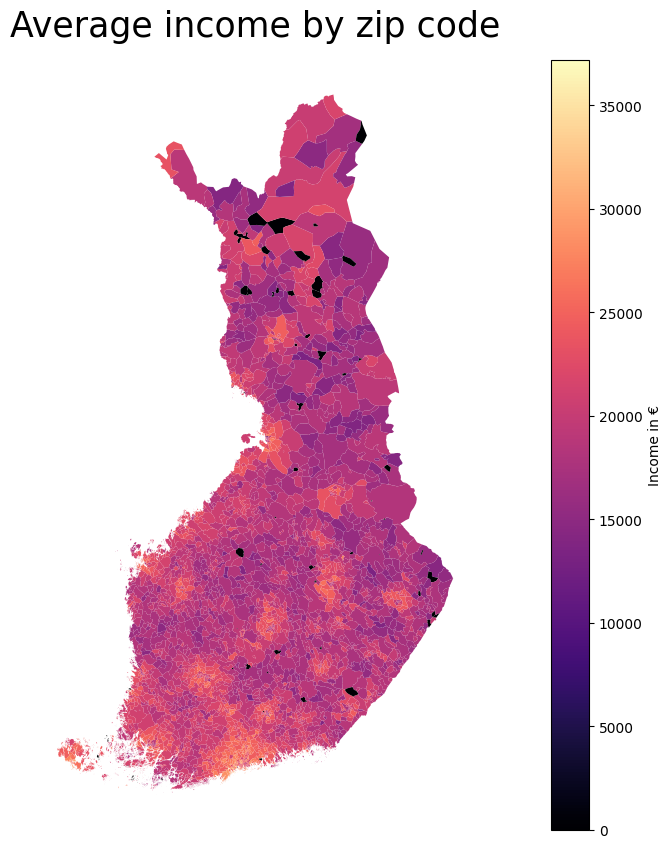

In [7]:
# check reference frame
print(original_gdf.crs)

fig, ax = plt.subplots(figsize=(20, 10))
# set title for the full plot
ax.set_title("Average income by zip code", fontsize=25)
# turn off all axes
ax.set_axis_off()
# plot the average income
plot = original_gdf.plot(column='hr_mtu', ax=ax, legend=True, cmap="magma")
# set colorbar label
cax = fig.get_axes()[1]
cax.set_ylabel('Income in €');


#### 2.3.3 Regression plots

We can also explore, how the different features are related to another by plotting them "against each other" by plotting some regression plots, i.e. scatter plots with a "best fitting" regression line. 

In [ ]:
variables = ['euref_x', 'euref_y', 'he_vakiy','he_3_6']

for var in variables:
    plt.figure() # Creating a rectangle (figure) for each plot
    # Regression Plot also by default includes best-fitting regression line which can be turned off via `fit_reg=False`
    sns.regplot(x=var, y='hr_mtu', data=original_gdf).set(title=f'Regression plot of {var} and average income');

: 

## 3. Feature selection

We have a lot of features available. 
It usually make sens to check for empty rows and columns as well as empty single cells and either remove them from the dataset or, if domain knowledge allows, fill them with sensible values. Note that this might have significant impact on the results. So fill with care, and if unsure, rather remove.


In [13]:

### Drop all rows that have missing values or where average income is -1 (=not known) or 0
original_gdf = original_gdf.dropna()    
original_gdf = original_gdf[original_gdf["hr_mtu"]>0].reset_index(drop=True)

print(f"Dataframe size after dropping no data rows: {len(original_gdf.index)} zip codes with {len(original_gdf.columns)} columns")

### Remove some columns that are strings (namn, kunta = name of the municipality in Finnish and Swedish.)
### or which might make the modeling too easy ('hr_mtu','hr_tuy','hr_pi_tul','hr_ke_tul','hr_hy_tul','hr_ovy')
columns_to_be_removed_completely = ['namn','kunta','hr_ktu','hr_tuy','hr_pi_tul','hr_ke_tul','hr_hy_tul','hr_ovy']
original_gdf = original_gdf.drop(columns_to_be_removed_completely,axis=1)

print(f"Dataframe size after dropping columns with string values and columns that make modeling too easy : {len(original_gdf.index)} zip codes with {len(original_gdf.columns)} columns")

Dataframe size after dropping no data rows: 2942 zip codes with 109 columns
Dataframe size after dropping columns with string values and columns that make modeling too easy : 2942 zip codes with 101 columns


## 4. Feature engineering

The location of the zip code area does not directly influence the average per capita income. However, we know (=domain knowledge) that people with higher income can afford to live in cities and near the coast or some other water body. So let's engineer some features that represent these factors:

* distance to closest city center
* number of lakes in the area
* distance to closest national park

Be creative! Check out what other datasets you have available that could help you!


In [ ]:

# distance to closest city center (?)
# number of lakes in the area (SYKE water areas)
# distance to closest national park (SYKE luonnonsuejelualue)
 

## 5. Feature encoding

* Most Machine Learning algorithms cannot handle categorical features per se, they have to be converted to numerical values
* Categorical features can be binary (True/False, 1/0), ordinal (low,medium,high) or nominal (monkey, donkey, tiger, penguin)

This does not make any sense, but to practice, we can add region names to the post codes. One of the most-used encoding techniques is **one-hot encoding**. This means that instead of one column with different names, we create <number of unique values in column> new columns and fill then with 1/0. 
-> Same information content but numerical cells and no hierarchy (as we would get when simply assigning a numerical value to each string) 
-> also called "dummy variables"

We use the pandas **get_dummies()** function for one-hot encoding. Scikit would also have a **OneHotEncoder()** transformer for this

* More information on one-hot encoding https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding
* It might not always be the best option. See other options https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809

### 5.1 Spatially join the region information to the dataset 

First we need to bring the two dataframes together. We want to know which region each zip code are is in, so we want to "spatially join" the two dataframes. As the zip code areas might overlap several regions, let's choose that region for each zip code, where the mid point of each zip code polygon falls in.

In [ ]:
### Read the regions shapefile and choose only the name of the region and its geometry
finnish_regions_gdf = gpd.read_file(finnish_regions_shapefile)
finnish_regions_gdf = finnish_regions_gdf[['NAMEFIN','geometry']]

### A function we use to return centroid point geometry from a zip code polygon
def returnPointGeometryFromXY(polygon_geometry):
    ## Calculate x and y of the centroid
    centroid_x,centroid_y = polygon_geometry.centroid.x,polygon_geometry.centroid.y
    ## Create a shapely Point geometry of the x and y coords
    point_geometry = Point(centroid_x,centroid_y)
    return point_geometry

### Stash the polygon geometry to another column as we are going to overwrite the 'geometry' with centroid geometry
original_gdf['polygon_geometry'] = original_gdf['geometry']

### We will be joining the region name to zip codes according to the zip code centroid. 
### This calls the function above and returns centroid to every row
original_gdf["geometry"] = original_gdf['geometry'].apply(returnPointGeometryFromXY)

### Spatially join the region name to the zip codes using the centroid of zip codes and region polygons
original_gdf = gpd.sjoin(original_gdf,finnish_regions_gdf,how='inner',op='intersects')
# look at the end of the dataframe to see if it worked (the beginning of the dataframe has too many zip codes in same area)
original_gdf.tail()

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,postinumer,nimi,hr_mtu,geometry,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,...,pt_vakiy,pt_tyoll,pt_tyott,pt_0_14,pt_opisk,pt_elakel,pt_muut,polygon_geometry,index_right,NAMEFIN
2937,99910,Kaamanen-Partakko,14958.0,POINT (503361.568 7678497.460),0.652824,0.934983,0.252585,0.005023,0.004094,0.006178,...,0.005127,0.003996,0.005880,0.002072,0.002740,0.010694,0.003094,"POLYGON ((525777.302 7700650.894, 525850.693 7...",7,Lappi
2938,99930,Sevettijärvi-Näätämö,16891.0,POINT (548890.739 7711836.158),0.721755,0.963719,0.375958,0.007240,0.005732,0.008857,...,0.007596,0.007239,0.011307,0.004375,0.001245,0.011637,0.003094,"POLYGON ((574352.412 7709596.307, 573120.967 7...",7,Lappi
2939,99950,Karigasniemi,20854.0,POINT (471402.146 7701544.993),0.605400,0.954666,0.254414,0.010010,0.008120,0.011835,...,0.010255,0.009425,0.004071,0.013125,0.003487,0.012581,0.005569,"POLYGON ((450197.347 7670193.165, 450054.015 7...",7,Lappi
2940,99980,Utsjoki Keskus,20153.0,POINT (502680.384 7734902.492),0.647052,0.981236,0.403985,0.024194,0.021290,0.026051,...,0.024915,0.018474,0.010855,0.020032,0.008966,0.041359,0.015470,"POLYGON ((519583.786 7768425.325, 519615.030 7...",7,Lappi
2941,99990,Nuorgam,21797.0,POINT (536019.915 7755327.036),0.712512,1.000000,0.109397,0.006760,0.006619,0.006922,...,0.007292,0.007088,0.004975,0.009440,0.002989,0.007548,0.006188,"POLYGON ((538700.093 7735625.716, 531298.591 7...",7,Lappi


### 5.2 One-hot encode the region name

Let's practice now the one-hot encoding on the spatially joined dataframe.

In [ ]:
### Switch the polygon geometry back to the 'geometry' field and drop uselesss columns
original_gdf['geometry'] = original_gdf['polygon_geometry']
original_gdf.drop(['index_right','polygon_geometry'],axis=1, inplace=True)

### Encode the region name with One-hot encoder (= in pandas, dummy encoding)
ohencoder = OneHotEncoder()
encoded_gdf = ohencoder.fit_transform(original_gdf['NAMEFIN'])

# the pandas way for reference
#encoded_gdf = pd.get_dummies(original_gdf['NAMEFIN'])

### Join original gdf and encoded gdf together
new_encoded_gdf = original_gdf.join(encoded_gdf).drop('NAMEFIN',axis=1)

### The resulting dataframe has Polygon and Multipolygon geometries. 
### This upcasts the polygons to multipolygon format so all of them have the same format
new_encoded_gdf["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon else feature for feature in new_encoded_gdf["geometry"]]
print("Dataframe size after adding region name: " + str(len(new_encoded_gdf.index))+ " zip codes with " + str(len(new_encoded_gdf.columns)) + " columns")

### Print the tail of the dataframe
new_encoded_gdf.tail()

Dataframe size after adding region name: 2942 zip codes with 120 columns


,postinumer,nimi,hr_mtu,geometry,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,...,Lappi,Pirkanmaa,Pohjanmaa,Pohjois-Karjala,Pohjois-Pohjanmaa,Pohjois-Savo,Päijät-Häme,Satakunta,Uusimaa,Varsinais-Suomi
2937,99910,Kaamanen-Partakko,14958.0,"MULTIPOLYGON (((525777.302 7700650.894, 525850...",0.652824,0.934983,0.252585,0.005023,0.004094,0.006178,...,1,0,0,0,0,0,0,0,0,0
2938,99930,Sevettijärvi-Näätämö,16891.0,"MULTIPOLYGON (((574352.412 7709596.307, 573120...",0.721755,0.963719,0.375958,0.007240,0.005732,0.008857,...,1,0,0,0,0,0,0,0,0,0
2939,99950,Karigasniemi,20854.0,"MULTIPOLYGON (((450197.347 7670193.165, 450054...",0.605400,0.954666,0.254414,0.010010,0.008120,0.011835,...,1,0,0,0,0,0,0,0,0,0
2940,99980,Utsjoki Keskus,20153.0,"MULTIPOLYGON (((519583.786 7768425.325, 519615...",0.647052,0.981236,0.403985,0.024194,0.021290,0.026051,...,1,0,0,0,0,0,0,0,0,0
2941,99990,Nuorgam,21797.0,"MULTIPOLYGON (((538700.093 7735625.716, 531298...",0.712512,1.000000,0.109397,0.006760,0.006619,0.006922,...,1,0,0,0,0,0,0,0,0,0


## 6. Train- Test split

In order to determine later, how well our models perform on previously unseen data we need to split the dataset into so-called train and test dataset. We use the training dataset during model training, so our regressor gets to know that dataset really well. The test dataset we only use for inference, i.e. to see how well our model can deal with previously unseen data. 



In [ ]:
### Split the gdf to x (the predictor attributes) and y (the attribute to be predicted)
y = original_gdf['hr_mtu'] # Average income

### Remove geometry and textual fields
x = original_gdf.drop(['geometry','postinumer','nimi','hr_mtu'],axis=1)

### Split both datasets to train (60%) and test (40%) datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, random_state=random_seed)




## 7. Feature Scaling

Feature Scaling is one of the most important data preparation steps. This is to avoid biasing algorithms that compute distances between features (e.g. like KNN, SVM and other non-treebased) towards numerically larger values. Feature scaling also helps the algorithm to train and converge faster.
The most popoular scaling techniques are normalization and standardization. Both scale the values of the current cell based on all given other cells, this means that scaling has to be done before train/test split to avoid bias towards unseen data. Apply to test set afterwards.

## 7.1 Normalization or min-max scaling 

* X_new = (X - X_min)/(X_max - X_min)
* Used when features are of different scales, eg average size of household (te_takk) and number of inhabitants of a certain age class (he_x_y) 
* Scales the values into range [0,1] or [-1,1]
* Data should not have any large outliers (data exploration!), as the rest of the data will be squashed into narrow range. -> Standardization is better option
* Scikit-learn: [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

## 7.2 Standardization or Z-score normalization

* X_new = (X - mean)/std
* Used when "zero mean and unit standard deviation" needs to be ensured, we are standardizing to achieve equal variance of features
* Not bound to specific range
* less affected by outliers, as range is not set outliers will not have influence on the range of other values
* "1 implies that the value for that case is one standard deviation above the mean"
* Scikit-learn: [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)


In [14]:
### Get list of all column headings
all_columns = list(original_gdf.columns)

### List the column names that we don't want to be scaled, like zip-code and nimi (both regarded as string, cannot be scaled),  and geometry (cannot be scaled as is)
col_names_no_scaling = ['postinumer','nimi','geometry']

### List of column names we want to scale. (all columns minus those we don't want)
col_names_to_scale = [column for column in all_columns if column not in col_names_no_scaling]

### Subset the data for only those to-be scaled
x_train_to_scale = x_train[col_names_to_scale]
# we do not need to scale the label, but we also need to scale the test data
x_test_to_scale = x_test[col_names_to_scale]


### Apply a Scikit StandardScaler() or MinMaxScaler() for all the columns left in dataframe
### You can also test both, store in different variables then
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_x_train_array = scaler.fit_transform(x_train_to_scale)

#we also need to scale x_test with the same scaler, note that we only transform , not fit the test data
scaled_x_test_array = scaler.transform(x_test_to_scale)


### You can save the scaler for later use. If there suddenly would be more zip codes in Finland, we should use the same scaler.
# dump(scaler, scaler_path, compress=True)

### Result is a numpy ndarray, which we pack back into geopandas dataframe
scaled_x_train = pd.DataFrame(scaled_x_train_array)
scaled_x_train.columns = col_names_to_scale

scaled_x_test = pd.DataFrame(scaled_x_test_array)
scaled_x_test.columns = col_names_to_scale



### Join the non-scaled columns back with the the scaled columns by index
full_scaled_x_train = x_train[col_names_no_scaling].join(scaled_x_train)
full_scaled_x_test = x_test[col_names_no_scaling].join(scaled_x_test)

full_scaled_x_train.head()

,postinumer,nimi,hr_mtu,geometry,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,...,tp_t_koti,tp_u_kans,tp_x_tunt,pt_vakiy,pt_tyoll,pt_tyott,pt_0_14,pt_opisk,pt_elakel,pt_muut
0,00100,Helsinki Keskusta - Etu-Töölö,27577.0,"POLYGON ((385653.893 6671591.048, 385573.619 6...",0.467824,0.029171,0.000303,0.679496,0.664961,0.644436,...,0.005376,0.379310,0.666667,0.693190,0.779370,0.317503,0.428966,0.301868,0.526026,0.505569
1,00120,Punavuori,27523.0,"POLYGON ((385316.092 6671076.984, 385279.611 6...",0.468701,0.028337,0.000029,0.263362,0.258205,0.249572,...,0.005376,0.034483,0.333333,0.268715,0.300106,0.123474,0.191112,0.100125,0.192640,0.240718
2,00130,Kaartinkaupunki,30479.0,"POLYGON ((386212.111 6671061.262, 386176.826 6...",0.469833,0.028373,0.000031,0.055110,0.053156,0.053591,...,0.005376,0.482759,0.333333,0.056022,0.062886,0.018544,0.037992,0.027646,0.040572,0.055693
3,00140,Kaivopuisto - Ullanlinna,29439.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552...",0.470071,0.027735,0.000102,0.291434,0.295189,0.265798,...,0.005376,0.103448,0.333333,0.297467,0.313226,0.118046,0.218052,0.119303,0.244535,0.284653
4,00150,Eira - Hernesaari,26546.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823...",0.468366,0.027381,0.000163,0.345510,0.344729,0.320729,...,0.053763,0.310345,0.333333,0.359414,0.415473,0.198100,0.223808,0.133250,0.241233,0.308168


# 8. Store the results

We will need the results of this notebook in two further notebooks, so we will store the prepared train and test datasets into gpkg. 
We also store the labels for train and test datasets.

In [17]:
### Write the prepared train and test zipcode datasets to geopackage
full_scaled_x_train.to_file(train_dataset_name, driver="GPKG")
full_scaled_x_test.to_file(test_dataset_name, driver="GPKG")


# Write the labels to pickle, as we do not need to read it outside of these notebooks, otherwise json or csv would be more compatible options
y_train.to_pickle(train_label_name)
y_test.to_pickle(test_label_name)
